# Using Landlab to Model Tectonic Activities in a Landscape Evolution Model 
This notebook is created as a part of the 2020 ESPIn summer school

**Authors**: Liang Xue, Chris Sheehan, Xiaoni Hu, Eyal Marder & Gustav Pallisgaard-Olesen

**Version**: This version of the notebook has complete documentation and comments made by Gustav Pallisgaard-Olesen and is modified to the EKT-lab tutorial format 

This notebook contains different examples of how to use Landlab components to simulate the evolution of detachment-limited channels under different cases of active uplift and how a changing surface load affects the elastic lithosphere.
It will also show some of the terrain analysis tools available in Landlab such as Chi-index analysis and slope steepness-indeces, and how these can help identify key features in landscape evolution. 

Each section will contain exercises designed to give the user hands-on experience with Landlab and the models and tools used in this notebook. 

For those who are unfamiliar with Landlab, it provides a Python-based environment of robust and well-tested components to build landscape models. It provides components for different types of flow for different uses in for example geomorphology, hydrology and glaciology, and makes coupling these components easy through common modelling interfaces.   

The goal with this notebook is to show how easily one can set up and run a simple LEM with different tectonic settings using Landlab, and how the time from reaserch idea to numerical modelling results can be accelerated using open-source software in the Landlab framework. 

The notebook will work the user through setting up a basic LEM first and then go through different applications of the basic model one can use to investigate different tectonic scenarios. In the end you will use your new knowledge to create your own LEM with tectonic elements, that you can look at with the terrain analysis tools provided with Landlab.

**Outline**:
1. A basic Landscape Evolution Model
2. Investigating lithospheric flexure 
3. Adding faulting to an LEM
4. Terrain analysis with Landlab
5. Creating your own LEM

All four sections in this notebook will: 
- Run the model on the same 200 by 200 rectangular grid
- Have north, east and west boundaries closed and the south boundary open
- Use the StreamPowerEroder, LinearDiffuser and FlowAccumulator components as a basis for the LEM

**Learning Objectives**
- Setting up an LEM using Landlab
- Applying components for different tectonic scenarios
- Applying different terrain analysis tools
- Analyzing an LEM with Landlab terrain analysis tools

## 1. A Basic Landscape Evolution Model
This first section describes the nescesarry steps to model the evolution of a landscape undergoing constant tectonic uplift using Landlab.   

First the nescessary python libraries and the Landlab components for the landscape evolution model are imported. The StreamPowerEroder, LinearDiffuser and FlowAccumulator components are used as the main components of the landscape model. RasterModelGrid is used to create the gridded terrain and imshow_grid is used for visualizing the results. The imshow_grid provides a warning message regarding some depreciation of some functions, which are not relevant for this case, hence the warnings are ignored.  

In [1]:
import numpy as np
from landlab import RasterModelGrid
from landlab.components import StreamPowerEroder, LinearDiffuser, FlowAccumulator
from landlab import imshow_grid
from matplotlib import pyplot as plt

import warnings
warnings.filterwarnings('ignore')

The size of the grid is defined to be 20 by 20 km:

In [2]:
number_of_rows = 200            
number_of_columns = 200        
dxy = 100                        

Landlab's RasterModelGrid is called and because a perfectly flat grid will cause problems with flow routing, random noise is created across the synthetic landscape:

In [3]:
mg = RasterModelGrid((number_of_rows, number_of_columns), dxy) # mg(model grid) is initialized

# Create random noise
np.random.seed(0)                                       # seed set to zero so our figures are reproducible
mg_noise = np.random.rand(mg.number_of_nodes)/1000.     # intial noise on elevation grid

# set up the elevation on the grid
zr = mg.add_zeros('node', 'topographic__elevation')     # elevation is set on the nodes to zero everywhere
zr += mg_noise                                          # the noise is added to the elevation on the nodes

The boundary conditions are set - here 1 means "open" and 4 means "closed":

In [4]:
East = 4 
North = 4
West = 4
South = 1

mg.set_status_at_node_on_edges(right=East, top=North, left=West, bottom=South)

The basic landscape model will be subject to uniform uplift with an uplift rate U: 

In [5]:
U = 1E-3     # [m/yr]
uplift_rate = np.ones(mg.number_of_nodes)*U

The timestep "dt" is set to 1 kyr and the total simulation time "tmax" is set to 300 kyr: 

In [6]:
dt = 1000       # time step [yr]
tmax = 3E5      # time for the model loop to run [yr]

The elapsed time and the time array is initialized for the time loop: 

In [7]:
total_time = 0 
t = np.arange(0, tmax, dt)
qs = np.zeros(len(t))           # (For Exercise 1) initializing sediment discharge 
max_z = np.zeros(len(t))        # (For Exercise 1) initializing max elevation 
num = 0                         # (For Exercise 1) initializing counter for qs and max_z 

Constants for the stream power equation and hillslope diffusion are defined:

In [8]:
min_drainage_area = 1000
K_hs = 1E-3
K_sp = 1E-4
m_sp = 0.5                  # exponent on drainage area in stream power equation 
n_sp = 1                    # exponent on slope in stream power equation

The Landlab components **FlowAccumulator**, **StreamPowerEroder** and **LinearDiffuser** are initialized.

**LinearDiffuser** allows for erosion by diffusion without deposition (as can be assumed for detatchment-limited bedrock erosion). 

**FlowAccumulator** accumulates flow and calculates drainage area to be used in the Fastscape stream power erosion-algorithm. 

**StreamPowerEroder** uses Fastscape to calculate fluvial incision with the stream power law.

In [9]:
frr = FlowAccumulator(mg) 
spr = StreamPowerEroder(mg, K_sp=K_sp, m_sp=m_sp, n_sp=n_sp, threshold_sp=0.0) #threshol_sp=0.0 defines the stream power below which no erosion occurs
dfn = LinearDiffuser(mg, linear_diffusivity=K_hs, deposit = False) 

Now the LEM can be advanced through time. The uniform uplift is applied to the elevation of the grid.

### <font color = green> EXERCISE 1-1: </font> 
<em>The following code cell will advance the LEM trough time, and it could be interesting to look at the erosion rate or sediment discharge through time. For this you will need to save a copy of the topography field zr before each time step, which can then be used to calculate the total change in landscape volume over time (the total sediment discharge). Calculate the maximum elevation for each time step as well, which we will plot alongside the sediment discharge afterwards. The sediment discharge **qs**, the maximum elevation **max_z** and the counter **num** has already been initialized, so use these as your variable names.</em> 

In [10]:
for ti in t:
    zr[mg.core_nodes] += uplift_rate[mg.core_nodes]*dt  # uplift the landscape
    
    ## YOUR CODE HERE: 
    topo_old = np.copy(zr)                              # topo_old used to calculate sediment discharge
    ################# 
    
    dfn.run_one_step(dt)                                # diffuse the landscape
    frr.run_one_step()                                  # route flow
    spr.run_one_step(dt)                                # fluvial incision
    
    ## YOUR CODE HERE:
    qs[num] = np.sum(topo_old-zr)*dxy*dxy/dt            # sediment discharge or erosion rate is calculated  
    max_z[num] = zr.max()                               # maximum elevation is saved for later use
    num += 1                                            # num is used as index for qs
    #################
    
    total_time += dt                                    # update time keeper

Visualizing the topography of the finished model can be done with imshow_grid:

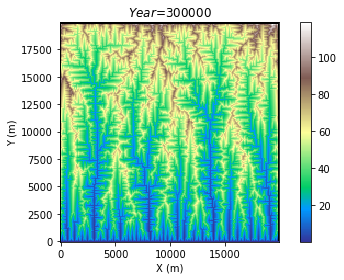

In [11]:
imshow_grid(mg, 'topographic__elevation', grid_units=('m', 'm'), cmap='terrain', allow_colorbar=True)
title_text = '$Year$='+str(total_time)  
plt.title(title_text)
plt.tight_layout()
plt.show()

To show some key features of the modelled lanscape evolution, sediment discharge and the maximum elevation are plotted through time:

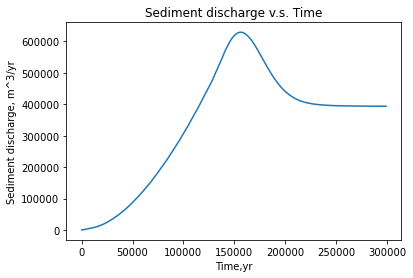

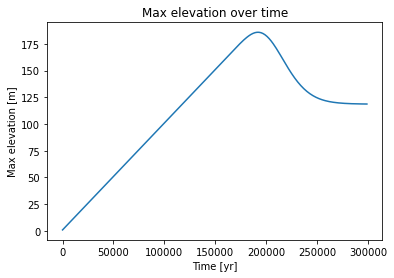

In [12]:
plt.plot(t,qs)
plt.title('Sediment discharge v.s. Time')
plt.xlabel('Time,yr')
plt.ylabel('Sediment discharge, m^3/yr')
plt.show()

plt.plot(t,max_z)
plt.title('Max elevation over time')
plt.xlabel('Time [yr]')
plt.ylabel('Max elevation [m]')
plt.show()

### <font color = green> EXERCISE 1-2: </font> 
<em>Look at the figures above. Sediment discharge increases until a certain point - then it decreases and reaches a constant value. The same pattern is seen in the maximum elevation. Explain why this is the case.</em> 

**Answer:**
The sediment discharge increases until a certain point between 150-200 kyr when the curve suddenly turns before it reaches equilibrium. The same is true for the maximum elevation, which increases linearly with the uplift rate until a certain point, when the highest areas of the landscape starts to erode and reach steady state. This effect is caused by the fact that knickpoints in the incised channels reach the drainage headwaters and can go no further. Afterwards, the landscape erodes to reach steady state at around 250 kyr.   

## 2. Investigating lithospheric flexure




In this section the Landlab component **Flexure** is used to calculate an instantaneous lithospheric deformation due to a point load in the landscape created in section 1. **Flexure** can be used to calculate lithospheric deformation in 1D or 2D. 

In this case, a simple point load is placed at the left boundary of the landscape. This is a very simple setup, but more advanced cased can easily be implemented with deformation across the entire landscape from sediment loads or erosional processes. The load is placed on the node grid created in section 1. A "column of sediment" is placed here with a density of 2700 $kg/m^3$ and a thickness of 1000 m.  

In [13]:
from landlab.components.flexure import Flexure

In [14]:
lith_press = mg.add_zeros("lithosphere__overlying_pressure_increment", at="node")
flex = Flexure(mg)

loads = mg.add_zeros('node', 'load')
dz_flex = mg.add_zeros('node', 'deflection')

### <font color = green> EXERCISE 2: </font> 
<em>In the following code cell, a point load (through the variable **loads**) is assigned to a node, and the landscape is subsided. Place a point load in a node and update the topography with the calculated deflection. Try to place the load in different areas and see the results in the figures.</em> 

2.64870E+07


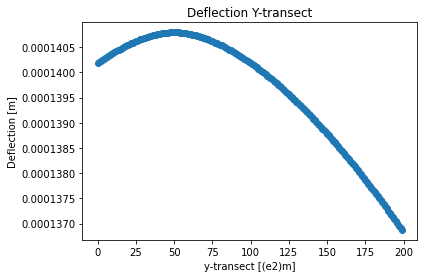

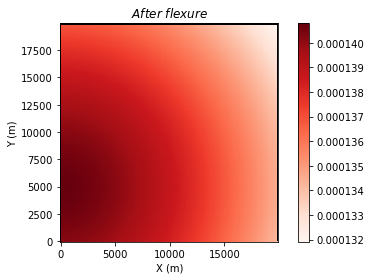

In [15]:
# Calculate flexure load
rho_s = 2700  # rock density (kg/m^3)
g = 9.81  # gravity constant (m/s^2)
h = 1000  # sediment fill thickness (m)

load = rho_s*9.81*h  # effective load (Pa)

# place the load 
## YOUR CODE HERE:
loads[10000] = load
#################

# Calculate deflection
dz_flex = flex.subside_loads(loads, out=None)
dz_flex = dz_flex.flatten()

# update topography
## YOUR CODE HERE:
zr -= dz_flex
#################

#Add deflection to grid
zr_deflection = mg.add_zeros('node', 'topographic__deflection')
zr_deflection += dz_flex 

# Plot deflection transect along the Y axis
tt = np.where(mg.node_x==0.0)

plt.plot(dz_flex[tt], 'o')
plt.xlabel('y-transect [(e2)m]')
plt.ylabel('Deflection [m]')
plt.title('Deflection Y-transect')

plt.show()

imshow_grid(mg, 'topographic__deflection', grid_units=('m', 'm'), cmap='Reds', allow_colorbar=True)
title_text = '$After$ $flexure$'
plt.title(title_text)
plt.tight_layout()
plt.show()

##  3. Adding faulting to an LEM



In this section the component NormalFault is used to create a fault which is subsequently propagated through the landscape. The NormalFault component allows for setting up faults with dip angle and slip rate. Furthermore, by having two zones with different stream power constants $K_{sp}$, representing different lithologies with vairous erodibilities, one can produce a more complex landscape. The components ChannelProfiler and ChiFinder are used to analyse the landscape after running the model. 

ChannelProfiler is simply a tool which can be used to plot channel profiles in a gridded landscape. 

The Chi($\chi$)-index can be used to check whether a channel is incised based on the stream power law. In this case $\chi$ plots linearly with elevation. Deviations from the stream power law is thus seen as nonlinearity on a $\chi$ against elevation plot.

In [16]:
from landlab.components import NormalFault, ChannelProfiler, ChiFinder

Because the previous section added a flexural response to the landscape, and in this section we focus on fault and lithology, so the basic model from section 1 is rerun in this section to reset the initial mesh condition. 

In [17]:
#concavity for use in SteepnessFinder and ChiFinder.
theta = m_sp / n_sp

#setting up lithology
Ksp = np.ones(mg.number_of_nodes)
Ksp [np.where(mg.node_y>10000)] = 1e-4
Ksp [np.where(mg.node_y<= 10000)] = 0.7e-3 
# please note there are landlab components on lithology (Lithology/Litholayer), allowing for 2.5D rock units setup.

frr = FlowAccumulator(mg) 
spr = StreamPowerEroder(mg, K_sp=Ksp, m_sp=m_sp, n_sp=n_sp, threshold_sp=0.0)
dfn = LinearDiffuser(mg, linear_diffusivity=K_hs, deposit = False)

# initialize the component that will calculate the chi index
cf = ChiFinder(mg, min_drainage_area=1000.0,
               reference_concavity= theta,
               use_true_dx=True)

Time is initialized once more.

In [18]:
tmax = 1e5+1
total_time = 0 
t = np.arange(0, tmax, dt)

The model is run. NormalFault is provided with the end points of the fault. Here a fault is placed diagonally across the landscape and propagated a few kilometers south during the simulation. A throw rate of $1.0 \cdot 10^{-3} \cdot 100m/kyr$ - the weird unit is simply a result of the units used in the basic model - which comes out as dx/dt = 100m/kyr.  

### <font color = green> EXERCISE 3: </font> 
<em>In the following code cell the basic model is rerun, but this time with a fault line cutting through the landscape. In this exercise you must assign the correct parameters to the Landlab component "NormalFault" in order to get a diagonal Fault going from bottom left to top right. The throw rate should be $1.0 \cdot 10^{-3} \cdot 100m/kyr$. Assign a dip angle, so the fault is vertical. The fault trace should move through time with a constant rate of 0 in the x-direction and $-0.5 \cdot 10^{-1} 100m/kyr$ in the y-direction.</em> 

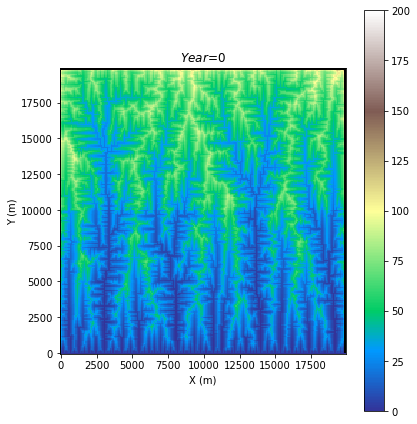

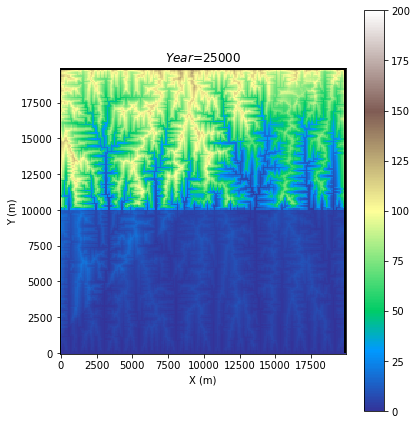

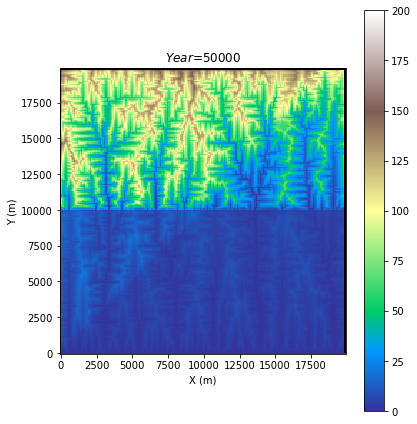

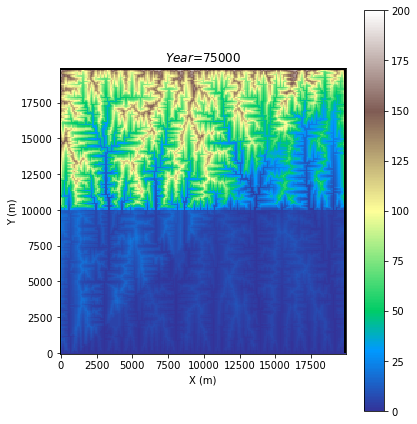

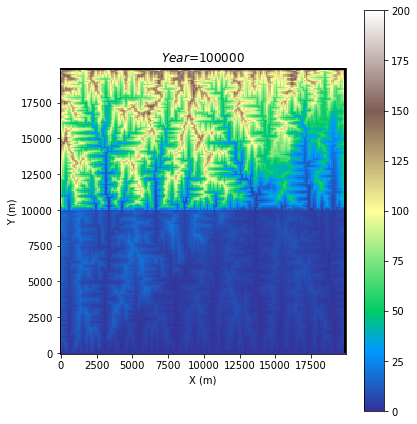

In [19]:
for ti in t:
    zr[mg.core_nodes] += uplift_rate[mg.core_nodes]*dt  # uplift the landscape
    dfn.run_one_step(dt)                                # diffuse the landscape
    frr.run_one_step()                                  # route flow
    spr.run_one_step(dt)                                # fluvial incision
    
    # fault  location solver
    # set up rate of fault propagation
    # def vectors dfx and dfy as the propagation rate
    
    ## YOUR CODE HERE:
    dfx = 0
    dfy = -0.5e-1
    #################
        
    # the rate can be time-dependant with dt
    xmax = dxy*mg.shape[0]
    ymax = dxy*mg.shape[1]

    # functions for the end points of the fault. Please note that this fault have to be linear. If the fault is curved,
    # you can change the below function accordingly. 
    x1, y1 = np.linalg.solve (np.array ([[1,-1], [1, 0]]), np.array ([-2500, 0]))
    x2, y2 = np.linalg.solve (np.array ([[1,-1], [0, 1]]), np.array ([-2500, ymax]))
    
    ## EXAMPLE OF THE PARAMETERS FOR NormalFault, the following code is for fault with fixed locaiton. 
    ## You can copy this and fill in the correct code
    # param_dict = {'faulted_surface': "your surface, in this case the topography",
    #             'fault_dip_angle': "angle for a vertical fault" ,
    #             'fault_throw_rate_through_time': {'time': [0, tmax],
    #                                               'rate': ["your throw rate", "your throw rate"]},
    #             'fault_trace': {'y1': "positions of your y1 coordinate through time", 
    #                            'x1': "positions of your x1 coordinate through time",
    #                            'y2': "positions of your y2 coordinate through time", 
    #                            'x2': "positions of your x2 coordinate through time"}, 
    #            'include_boundaries': False}
    
    ## EXAMPLE OF THE PARAMETERS FOR NormalFault, the following code is for fault with constant slip rake dfx/dfy.
    ## Please note that the slip rate (dfx, dfy) can also be specified in functoin of time. 
    ## YOUR CODE HERE:
    param_dict = {'faulted_surface': 'topographic__elevation',
                 'fault_dip_angle': 90.0,
                 'fault_throw_rate_through_time': {'time': [0, tmax],
                                                   'rate': [1e-3, 1e-3]},
                 'fault_trace': {'y1': y1 + dfy*total_time, 
                                'x1': x1 + dfx*total_time,
                                'y2': y2 + dfy*total_time, 
                                'x2': x2 + dfx*total_time}, 
                'include_boundaries': False}
    #################

    # Run NormalFault
    ft = NormalFault(mg, **param_dict)
    ft.faulted_nodes.reshape(mg.shape)
    ft.run_one_step(dt)                               
    
# plot figure
# plot figure every 2.5 kyr
    if ti %25000 == 0:
        plt.figure(figsize = (6,6))
        imshow_grid(mg, 'topographic__elevation', grid_units=('m', 'm'), vmin= 0, vmax = 200,
            cmap='terrain', allow_colorbar=True)
        title_text = '$Year$='+str(total_time)  
        plt.title(title_text)
        plt.tight_layout()
    total_time += dt                                    # update time keeper
    #print(total_time)

The different lithological domains is easily seen in the model output. The higher stream power K-value in the bottom half of the model increases the erodibility compared to the base model, and the landscape quickly becomes fairly flat. The diagonal fault can also be seen propagating south through the landscape. 

The features seen in the model output can be analyzed with ChannelProfiler and ChiFinder. Firstly the channel profiles can be plotted with ChannelProfiler. The five longest channels are found, and their profiles plotted as elevation vs distance upstream.

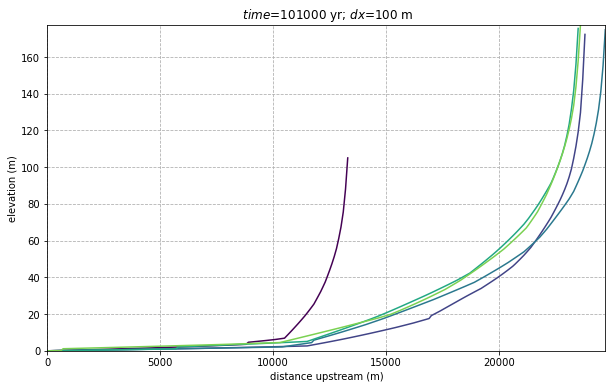

In [20]:
flow__receiver_node = mg.at_node['flow__receiver_node']
indices = np.where(mg.status_at_node[flow__receiver_node] == 0)

#calculated the first five longest channal 
indices = np.where(mg.status_at_node[flow__receiver_node] == 0)
prf = ChannelProfiler(mg, number_of_watersheds =5,
                     minimum_channel_threshold = dxy**2)
prf.run_one_step()

plt.figure(figsize = (10,6))
title_text = f" $time$={total_time} yr; $dx$={dxy} m"
prf.plot_profiles(xlabel='distance upstream (m)',
                  ylabel='elevation (m)',
                  title=title_text)
plt.grid(linestyle='--')
plt.rcParams.update({'font.size':14})

The five longest river channels can also be plotted on the map:

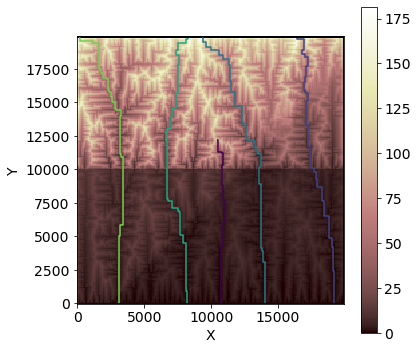

In [21]:
plt.figure(figsize = (6,6))
prf.plot_profiles_in_map_view()

The channel profiles show the flat lowland caused by the high erodibility in the lower half of the landscape in the interval 0-10000 m upstream. Small breaks in the curves are caused by the fault. They are more easily seen in the rightmost river profile (a light purpe color) because the fault crosses the river outside of the lowlands. 

Next the channel slope can be plotted against the drainage area. The slope and the drainage area generally follow a power relationship, and thus show linearity in loglog-space. The same five river profiles are used.

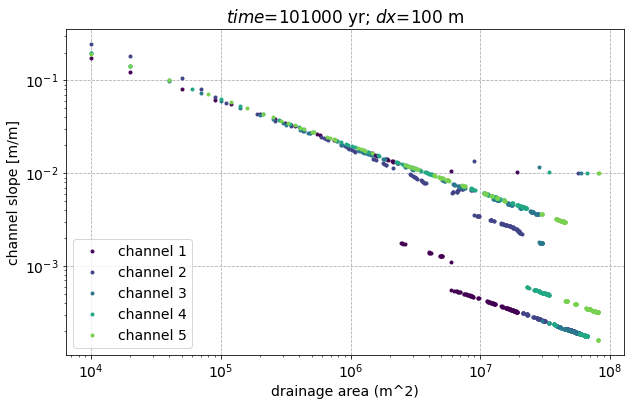

In [22]:
plt.figure(figsize = (10,6))
for i, outlet_id in enumerate(prf.data_structure):
    for j, segment_id in enumerate(prf.data_structure[outlet_id]):
        if j == 0:
            label = "channel {i}".format(i=i + 1)
        else:
            label = '_nolegend_'
        segment = prf.data_structure[outlet_id][segment_id]
        profile_ids = segment["ids"]
        color = segment["color"]
        plt.loglog(
            mg.at_node["drainage_area"][profile_ids],
            mg.at_node["topographic__steepest_slope"][profile_ids],
            '.',
            color=color,
            label=label,
        )

plt.legend(loc="lower left")
plt.xlabel("drainage area (m^2)")
plt.ylabel("channel slope [m/m]")
title_text = f"$time$={total_time} yr; $dx$={dxy} m"
plt.title(title_text)
plt.grid(linestyle='--')

This figure also show signs of both the different lithological domains and the fault line going through the channels. Taking a look at channel 1 clearly shows a significant decrease in channel slope (drainage area ~2e6) due to the change in lithology and again at drainage areas of ~6e6 due to the fault line crossing the river and creating differential uplift rates along the channel profile. 

Finally the $\chi$-index is calculated and plotted for the same five channel profiles: 

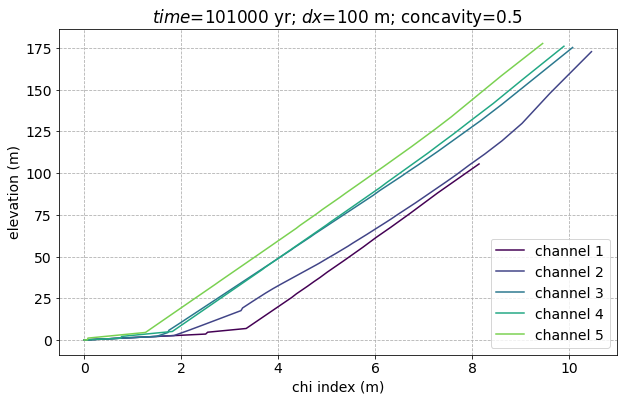

In [23]:
cf.calculate_chi()

# chi-elevation plots in the profiled channels
plt.figure(figsize = (10,6))

for i, outlet_id in enumerate(prf.data_structure):
    for j, segment_id in enumerate(prf.data_structure[outlet_id]):
        if j == 0:
            label = "channel {i}".format(i=i + 1)
        else:
            label = '_nolegend_'
        segment = prf.data_structure[outlet_id][segment_id]
        profile_ids = segment["ids"]
        color = segment["color"]
        plt.plot(
            mg.at_node["channel__chi_index"][profile_ids],
            mg.at_node["topographic__elevation"][profile_ids],
            color=color,
            label=label,
        )

plt.xlabel("chi index (m)")
plt.ylabel("elevation (m)")
plt.legend(loc="lower right")
title_text = f"$time$={total_time} yr; $dx$={dxy} m; concavity={m_sp/n_sp}"
plt.title(title_text)
plt.grid(linestyle='--')

The $\chi$-index very clearly shows the change in lithologies in the low-range of $\chi$-values. The lines are broken into two linear curves (which is to be expected as the channels are incised by stream power erosion). The influence of the fault is not as pronounced, but cat still be seen as smaller jumps in the curves especially in channel 1 and channel 2 where the fault intersects outside the highly erodible lower domain.

## 4. Terrain analysis with Landlab

In the final section, ChannelProfiler, SteepnessFinder, ChiFinder are used to visualize knickpoint migration in the synthetic landscape from section 1. The landscape was uplifted uniformly and reached steady state, but in this section a second instantaneous uplift event will pertube the landscape, which will cause new knickpoints to migrate through the channel system. These cannot easily be seen in the landscape as for example the fault in the last section, but they can be shown clearly by using some of the build in terrain analysis tools in Landlab.

In addition to the tools used in section 3, SteepnessFinder will also be used. SteepnessFinder is used to calculate the channel steepness index, assuming erosion by stream power, and is constant for a steady state landscape. The slope steepness can for example be used to analyse knickpoint migration, which it is going to be used for in this section.

Again the base model needs to be rerun because the landscape now includes a fault and different lithological domains.

In [24]:
from landlab.components import SteepnessFinder

Rerunning the basic model setup from section 1:

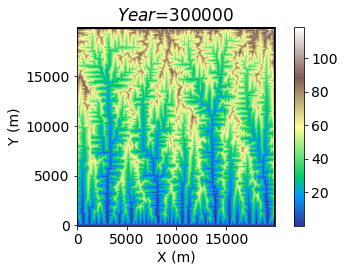

In [25]:
mg = RasterModelGrid((number_of_rows, number_of_columns), dxy)

# Create random noise
np.random.seed(0)                                       # seed set to zero so our figures are reproducible
mg_noise = np.random.rand(mg.number_of_nodes)/1000.     # intial noise on elevation grid

# set up the elevation on the grid
zr = mg.add_zeros('node', 'topographic__elevation')
zr += mg_noise
mg.set_status_at_node_on_edges(right=East, top=North, left=West, bottom=South)

U = 1E-3
uplift_rate = np.ones(mg.number_of_nodes)*U

dt = 1000            # time step [yr]
tmax = 3E5        # time for the model loop to run [yr]
total_time = 0 
t = np.arange(0, tmax, dt)

min_drainage_area = 1000
K_hs = 1E-3
K_sp = 1E-4
m_sp = 0.5                  # exponent on drainage area in stream power equation 
n_sp = 1                    # exponent on slope in stream power equation

frr = FlowAccumulator(mg) 
spr = StreamPowerEroder(mg, K_sp=K_sp, m_sp=m_sp, n_sp=n_sp, threshold_sp=0.0)
dfn = LinearDiffuser(mg, linear_diffusivity=K_hs, deposit = False)

# initialize the component that will calculate channel steepness
sf = SteepnessFinder(mg,reference_concavity=theta, min_drainage_area=1000.0)

for ti in t:
    zr[mg.core_nodes] += uplift_rate[mg.core_nodes]*dt  # uplift the landscape
    dfn.run_one_step(dt)                                # diffuse the landscape
    frr.run_one_step()                                  # route flow
    spr.run_one_step(dt)                                # fluvial incision
    total_time += dt                                    # update time keeper

imshow_grid(mg, 'topographic__elevation', grid_units=('m', 'm'), cmap='terrain', allow_colorbar=True)
title_text = '$Year$='+str(total_time)  
plt.title(title_text)
plt.tight_layout()
plt.show()

This landscape is identical to the steady state landscape created in section 1.

The ChannelProfiler is used to plot a channel profile from a river in the landscape. The method is the same as used in section 3. Furthermore channel slope vs. drainage area is plotted, which for a river incised with stream power erosion in a steady state system should be linear.

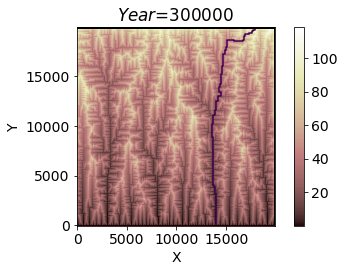

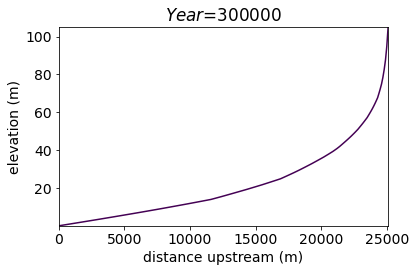

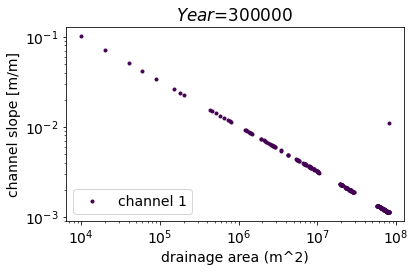

In [26]:
prf = ChannelProfiler(mg, number_of_watersheds=1, main_channel_only=True, minimum_channel_threshold=min_drainage_area)
prf.run_one_step()

plt.figure(1)
prf.plot_profiles_in_map_view()
plt.title(title_text)
plt.tight_layout()
plt.show()

plt.figure(2)
prf.plot_profiles(xlabel='distance upstream (m)', ylabel='elevation (m)')
title_text = '$Year$='+str(total_time)  
plt.title(title_text)
plt.tight_layout()
plt.show()

plt.figure(3)
for i, outlet_id in enumerate(prf.data_structure):
    for j, segment_id in enumerate(prf.data_structure[outlet_id]):
        if j == 0:
            label = "channel {i}".format(i=i + 1)
        else:
            label = '_nolegend_'
        segment = prf.data_structure[outlet_id][segment_id]
        profile_ids = segment["ids"]
        color = segment["color"]
        plt.loglog(mg.at_node["drainage_area"][profile_ids], mg.at_node["topographic__steepest_slope"][profile_ids], '.', color=color, label=label)
plt.legend(loc="lower left")
plt.xlabel("drainage area (m^2)")
plt.ylabel("channel slope [m/m]")
title_text = '$Year$='+str(total_time)  
plt.title(title_text)
plt.tight_layout()
plt.show()

The figures look as expected. In the top figure, the channel to be analyzed in this section is shown in purple. The middle figure shows the steady state concave river profile and the bottom figure shows the linear relationship between the channel slope and the drainage area. 

Next the SteepnessFinder is initialized:

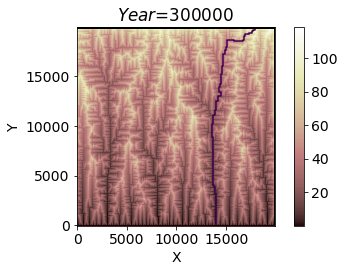

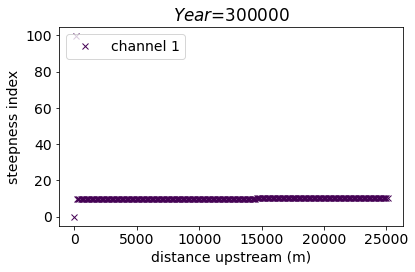

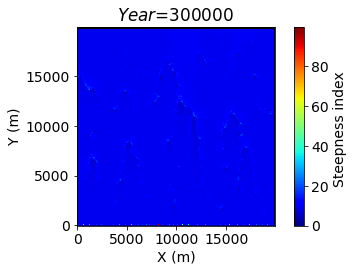

In [27]:
sf = SteepnessFinder(mg, reference_concavity=m_sp/n_sp, min_drainage_area=min_drainage_area)
sf.calculate_steepnesses()

plt.figure(1)
prf.plot_profiles_in_map_view()
plt.title(title_text)
plt.tight_layout()
plt.show()

plt.figure(2)
for i, outlet_id in enumerate(prf.data_structure):
    for j, segment_id in enumerate(prf.data_structure[outlet_id]):
        if j == 0:
            label = "channel {i}".format(i=i + 1)
        else:
            label = '_nolegend_'
        segment = prf.data_structure[outlet_id][segment_id]
        profile_ids = segment["ids"]
        distance_upstream = segment["distances"]
        color = segment["color"]
        plt.plot(distance_upstream, mg.at_node["channel__steepness_index"][profile_ids], 'x', color=color, label=label)
plt.xlabel("distance upstream (m)")
plt.ylabel("steepness index")
plt.legend(loc="upper left")
title_text = '$Year$='+str(total_time)  
plt.title(title_text)
plt.tight_layout()
plt.show()

plt.figure(3)
imshow_grid(mg, "channel__steepness_index", grid_units=("m", "m"), var_name="Steepness index ", cmap="jet")
title_text = '$Year$='+str(total_time)  
plt.title(title_text)
plt.tight_layout()
plt.show()


These figures show that the steepness index is constant, which it should be for a steady state landscape.

Lastly, the ChiFinder can be used to check the state of the landscape:

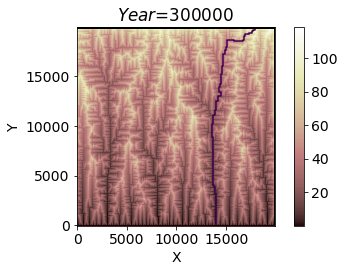

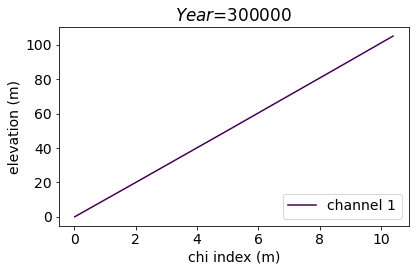

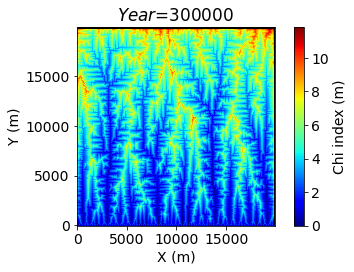

In [28]:
cf = ChiFinder(mg, reference_concavity=m_sp/n_sp, min_drainage_area=min_drainage_area)
cf.calculate_chi()

plt.figure(1)
prf.plot_profiles_in_map_view()
plt.title(title_text)
plt.tight_layout()
plt.show()

plt.figure(2)
for i, outlet_id in enumerate(prf.data_structure):
    for j, segment_id in enumerate(prf.data_structure[outlet_id]):
        if j == 0:
            label = "channel {i}".format(i=i + 1)
        else:
            label = '_nolegend_'
        segment = prf.data_structure[outlet_id][segment_id]
        profile_ids = segment["ids"]
        color = segment["color"]
        plt.plot(mg.at_node["channel__chi_index"][profile_ids], mg.at_node["topographic__elevation"][profile_ids], color=color, label=label)
plt.xlabel("chi index (m)")
plt.ylabel("elevation (m)")
plt.legend(loc="lower right")
title_text = '$Year$='+str(total_time)  
plt.title(title_text)
plt.tight_layout()
plt.show()

plt.figure(3)
imshow_grid(mg, "channel__chi_index", grid_units=("m", "m"), var_name="Chi index (m)", cmap="jet")
title_text = '$Year$='+str(total_time)  
plt.title(title_text)
plt.tight_layout()
plt.show()

The $\chi$-index is linear with elevation, which again is the sign of a steady state landscape.

This is the starting point before the next uplift event, which instead of just the constant uplift in the basic model will include an additional instantanious uplift of 50 meters.

Here the 50 meter uplift happens instantaneously and the model is advanced 10,000 years:

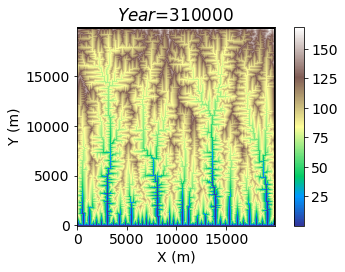

In [29]:
zr[mg.core_nodes] += 50
dt = 1000            
tmax = 1E4  
t = np.arange(0, tmax, dt)
for ti in t:
    zr[mg.core_nodes] += uplift_rate[mg.core_nodes]*dt  
    dfn.run_one_step(dt)                                
    frr.run_one_step()                                  
    spr.run_one_step(dt)                                
    total_time += dt                                    
plt.figure(1)
imshow_grid(mg, 'topographic__elevation', grid_units=('m', 'm'), cmap='terrain', allow_colorbar=True)
title_text = '$Year$='+str(total_time)  
plt.title(title_text)
plt.tight_layout()
plt.show()

The terrain analysis tools used to look at the steady state landscape are used again to visualize the changes in the channel system:

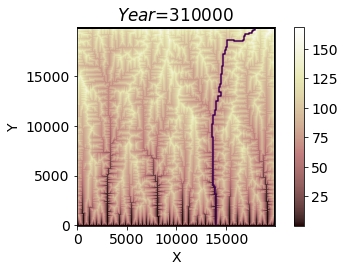

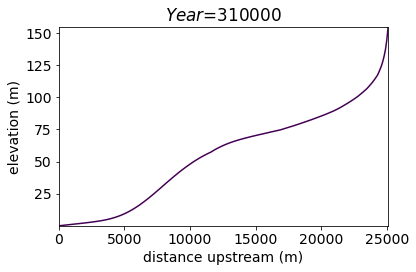

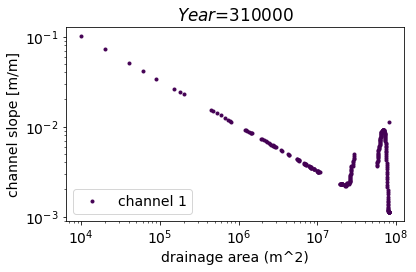

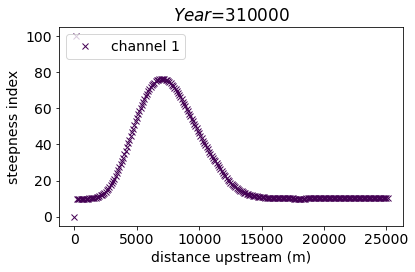

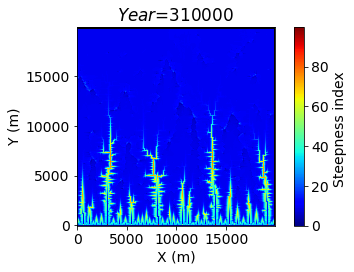

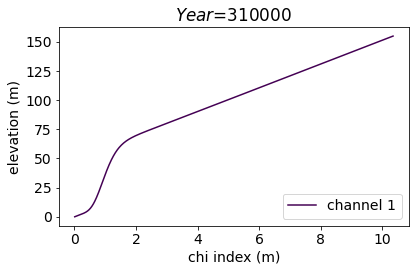

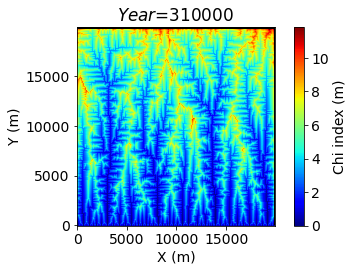

In [30]:
prf.run_one_step()

plt.figure(1)
prf.plot_profiles_in_map_view()
plt.title(title_text)
plt.tight_layout()
plt.show()

plt.figure(2)
prf.plot_profiles(xlabel='distance upstream (m)', ylabel='elevation (m)')
title_text = '$Year$='+str(total_time)  
plt.title(title_text)
plt.tight_layout()
plt.show()

plt.figure(3)
for i, outlet_id in enumerate(prf.data_structure):
    for j, segment_id in enumerate(prf.data_structure[outlet_id]):
        if j == 0:
            label = "channel {i}".format(i=i + 1)
        else:
            label = '_nolegend_'
        segment = prf.data_structure[outlet_id][segment_id]
        profile_ids = segment["ids"]
        color = segment["color"]
        plt.loglog(mg.at_node["drainage_area"][profile_ids], mg.at_node["topographic__steepest_slope"][profile_ids], '.', color=color, label=label)
plt.legend(loc="lower left")
plt.xlabel("drainage area (m^2)")
plt.ylabel("channel slope [m/m]")
title_text = '$Year$='+str(total_time)  
plt.title(title_text)
plt.tight_layout()
plt.show()

sf.calculate_steepnesses()

plt.figure(4)
for i, outlet_id in enumerate(prf.data_structure):
    for j, segment_id in enumerate(prf.data_structure[outlet_id]):
        if j == 0:
            label = "channel {i}".format(i=i + 1)
        else:
            label = '_nolegend_'
        segment = prf.data_structure[outlet_id][segment_id]
        profile_ids = segment["ids"]
        distance_upstream = segment["distances"]
        color = segment["color"]
        plt.plot(distance_upstream, mg.at_node["channel__steepness_index"][profile_ids], 'x', color=color, label=label)
plt.xlabel("distance upstream (m)")
plt.ylabel("steepness index")
plt.legend(loc="upper left")
title_text = '$Year$='+str(total_time)  
plt.title(title_text)
plt.tight_layout()
plt.show()

plt.figure(5)
imshow_grid(mg, "channel__steepness_index", grid_units=("m", "m"), var_name="Steepness index ", cmap="jet")
title_text = '$Year$='+str(total_time)  
plt.title(title_text)
plt.tight_layout()
plt.show()

cf.calculate_chi()

plt.figure(6)
for i, outlet_id in enumerate(prf.data_structure):
    for j, segment_id in enumerate(prf.data_structure[outlet_id]):
        if j == 0:
            label = "channel {i}".format(i=i + 1)
        else:
            label = '_nolegend_'
        segment = prf.data_structure[outlet_id][segment_id]
        profile_ids = segment["ids"]
        color = segment["color"]
        plt.plot(mg.at_node["channel__chi_index"][profile_ids], mg.at_node["topographic__elevation"][profile_ids], color=color, label=label)
plt.xlabel("chi index (m)")
plt.ylabel("elevation (m)")
plt.legend(loc="lower right")
title_text = '$Year$='+str(total_time)  
plt.title(title_text)
plt.tight_layout()
plt.show()

plt.figure(7)
imshow_grid(mg, "channel__chi_index", grid_units=("m", "m"), var_name="Chi index (m)", cmap="jet")
title_text = '$Year$='+str(total_time)  
plt.title(title_text)
plt.tight_layout()
plt.show()

### <font color = green> EXERCISE 4-1: </font> 
<em>The changes in the landscape is reflected in the figures above. Why have they changed shape? Go through each figure and explain how the changes in the figures reflect the changes in the landscape.</em> 

**Answer:**
The changes in the landscape is reflected in the figures above. Elevation vs. distance shows that the river profile is no longer concave. Channel slope vs. drainage area shows the uplift event as a pertubation in channel slope for high drainage areas. The pertubation can thus be seen as a steepening of the slopes in the lowland areas. This is where the knickpoint in the channel starts. This knickpoint can be seen in the steepness index migrating from the lowland areas. The $\chi$-index clearly shows a pertubation of 50 meters and the knickpoint starting in the lowland area. 

The landscape is advanced another 40,000 years:

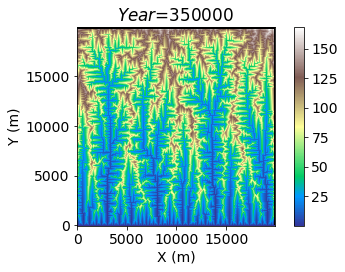

In [31]:
dt = 1000            
tmax = 4E4  
t = np.arange(0, tmax, dt)
for ti in t:
    zr[mg.core_nodes] += uplift_rate[mg.core_nodes]*dt  
    dfn.run_one_step(dt)                                
    frr.run_one_step()                                  
    spr.run_one_step(dt)                                
    total_time += dt                                    
plt.figure(1)
imshow_grid(mg, 'topographic__elevation', grid_units=('m', 'm'), cmap='terrain', allow_colorbar=True)
title_text = '$Year$='+str(total_time)  
plt.title(title_text)
plt.tight_layout()
plt.show()

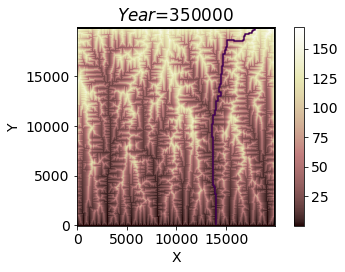

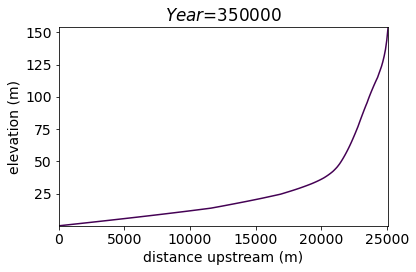

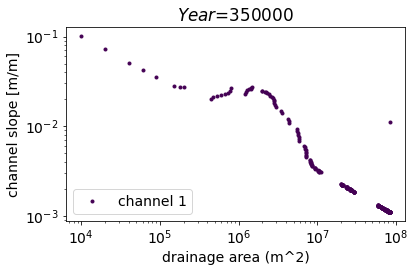

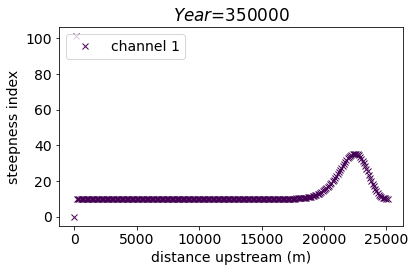

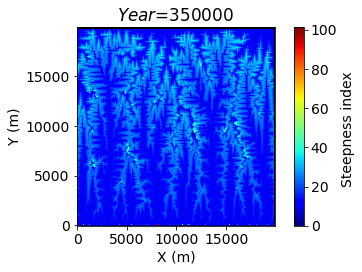

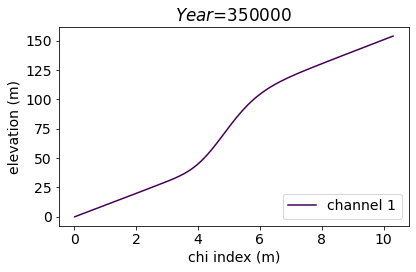

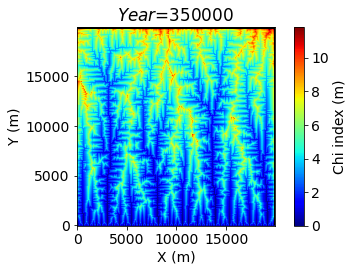

In [32]:
prf.run_one_step()

plt.figure(1)
prf.plot_profiles_in_map_view()
plt.title(title_text)
plt.tight_layout()
plt.show()

plt.figure(2)
prf.plot_profiles(xlabel='distance upstream (m)', ylabel='elevation (m)')
title_text = '$Year$='+str(total_time)  
plt.title(title_text)
plt.tight_layout()
plt.show()

plt.figure(3)
for i, outlet_id in enumerate(prf.data_structure):
    for j, segment_id in enumerate(prf.data_structure[outlet_id]):
        if j == 0:
            label = "channel {i}".format(i=i + 1)
        else:
            label = '_nolegend_'
        segment = prf.data_structure[outlet_id][segment_id]
        profile_ids = segment["ids"]
        color = segment["color"]
        plt.loglog(mg.at_node["drainage_area"][profile_ids], mg.at_node["topographic__steepest_slope"][profile_ids], '.', color=color, label=label)
plt.legend(loc="lower left")
plt.xlabel("drainage area (m^2)")
plt.ylabel("channel slope [m/m]")
title_text = '$Year$='+str(total_time)  
plt.title(title_text)
plt.tight_layout()
plt.show()

sf.calculate_steepnesses()

plt.figure(4)
for i, outlet_id in enumerate(prf.data_structure):
    for j, segment_id in enumerate(prf.data_structure[outlet_id]):
        if j == 0:
            label = "channel {i}".format(i=i + 1)
        else:
            label = '_nolegend_'
        segment = prf.data_structure[outlet_id][segment_id]
        profile_ids = segment["ids"]
        distance_upstream = segment["distances"]
        color = segment["color"]
        plt.plot(distance_upstream, mg.at_node["channel__steepness_index"][profile_ids], 'x', color=color, label=label)
plt.xlabel("distance upstream (m)")
plt.ylabel("steepness index")
plt.legend(loc="upper left")
title_text = '$Year$='+str(total_time)  
plt.title(title_text)
plt.tight_layout()
plt.show()

plt.figure(5)
imshow_grid(mg, "channel__steepness_index", grid_units=("m", "m"), var_name="Steepness index ", cmap="jet")
title_text = '$Year$='+str(total_time)  
plt.title(title_text)
plt.tight_layout()
plt.show()

cf.calculate_chi()

plt.figure(6)
for i, outlet_id in enumerate(prf.data_structure):
    for j, segment_id in enumerate(prf.data_structure[outlet_id]):
        if j == 0:
            label = "channel {i}".format(i=i + 1)
        else:
            label = '_nolegend_'
        segment = prf.data_structure[outlet_id][segment_id]
        profile_ids = segment["ids"]
        color = segment["color"]
        plt.plot(mg.at_node["channel__chi_index"][profile_ids], mg.at_node["topographic__elevation"][profile_ids], color=color, label=label)
plt.xlabel("chi index (m)")
plt.ylabel("elevation (m)")
plt.legend(loc="lower right")
title_text = '$Year$='+str(total_time)  
plt.title(title_text)
plt.tight_layout()
plt.show()

plt.figure(7)
imshow_grid(mg, "channel__chi_index", grid_units=("m", "m"), var_name="Chi index (m)", cmap="jet")
title_text = '$Year$='+str(total_time)  
plt.title(title_text)
plt.tight_layout()
plt.show()

### <font color = green> EXERCISE 4-2: </font> 
<em>The landscape is advanced 40,000 years through time, and the changes are again reflected in the figures. Explain what happened from the last exercise to this point in time 40,000 years later.</em>

**Answer:**
In the next 40,000 years, the knickpoint has migrated to the highlands. 

Lastly, the landscape is advanced another 150,000 years:

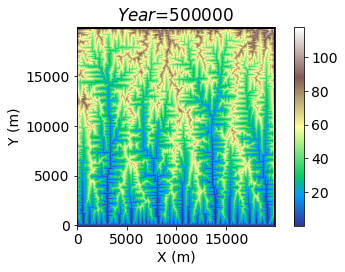

In [33]:
dt = 1000            
tmax = 1.5E5  
t = np.arange(0, tmax, dt)
for ti in t:
    zr[mg.core_nodes] += uplift_rate[mg.core_nodes]*dt  
    dfn.run_one_step(dt)                                
    frr.run_one_step()                                  
    spr.run_one_step(dt)                                
    total_time += dt                                    
plt.figure(1)
imshow_grid(mg, 'topographic__elevation', grid_units=('m', 'm'), cmap='terrain', allow_colorbar=True)
title_text = '$Year$='+str(total_time)  
plt.title(title_text)
plt.tight_layout()
plt.show()

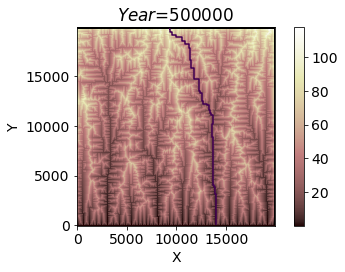

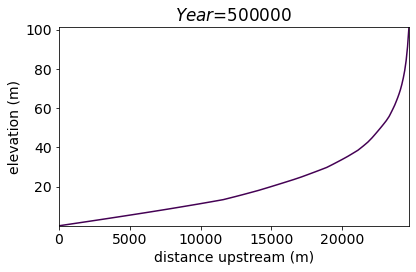

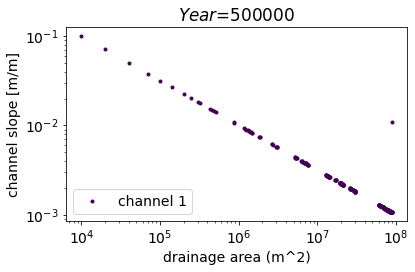

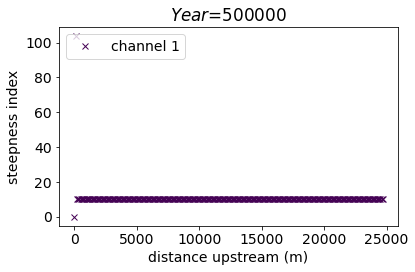

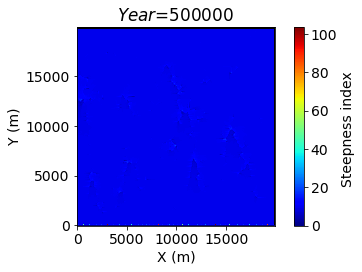

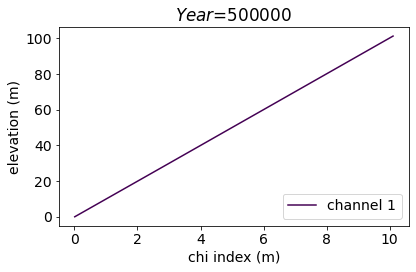

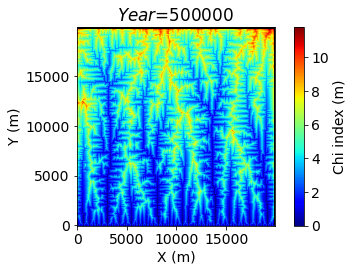

In [34]:
prf.run_one_step()

plt.figure(1)
prf.plot_profiles_in_map_view()
plt.title(title_text)
plt.tight_layout()
plt.show()

plt.figure(2)
prf.plot_profiles(xlabel='distance upstream (m)', ylabel='elevation (m)')
title_text = '$Year$='+str(total_time)  
plt.title(title_text)
plt.tight_layout()
plt.show()

plt.figure(3)
for i, outlet_id in enumerate(prf.data_structure):
    for j, segment_id in enumerate(prf.data_structure[outlet_id]):
        if j == 0:
            label = "channel {i}".format(i=i + 1)
        else:
            label = '_nolegend_'
        segment = prf.data_structure[outlet_id][segment_id]
        profile_ids = segment["ids"]
        color = segment["color"]
        plt.loglog(mg.at_node["drainage_area"][profile_ids], mg.at_node["topographic__steepest_slope"][profile_ids], '.', color=color, label=label)
plt.legend(loc="lower left")
plt.xlabel("drainage area (m^2)")
plt.ylabel("channel slope [m/m]")
title_text = '$Year$='+str(total_time)  
plt.title(title_text)
plt.tight_layout()
plt.show()

sf.calculate_steepnesses()

plt.figure(4)
for i, outlet_id in enumerate(prf.data_structure):
    for j, segment_id in enumerate(prf.data_structure[outlet_id]):
        if j == 0:
            label = "channel {i}".format(i=i + 1)
        else:
            label = '_nolegend_'
        segment = prf.data_structure[outlet_id][segment_id]
        profile_ids = segment["ids"]
        distance_upstream = segment["distances"]
        color = segment["color"]
        plt.plot(distance_upstream, mg.at_node["channel__steepness_index"][profile_ids], 'x', color=color, label=label)
plt.xlabel("distance upstream (m)")
plt.ylabel("steepness index")
plt.legend(loc="upper left")
title_text = '$Year$='+str(total_time)  
plt.title(title_text)
plt.tight_layout()
plt.show()

plt.figure(5)
imshow_grid(mg, "channel__steepness_index", grid_units=("m", "m"), var_name="Steepness index ", cmap="jet")
title_text = '$Year$='+str(total_time)  
plt.title(title_text)
plt.tight_layout()
plt.show()

cf.calculate_chi()

plt.figure(6)
for i, outlet_id in enumerate(prf.data_structure):
    for j, segment_id in enumerate(prf.data_structure[outlet_id]):
        if j == 0:
            label = "channel {i}".format(i=i + 1)
        else:
            label = '_nolegend_'
        segment = prf.data_structure[outlet_id][segment_id]
        profile_ids = segment["ids"]
        color = segment["color"]
        plt.plot(mg.at_node["channel__chi_index"][profile_ids], mg.at_node["topographic__elevation"][profile_ids], color=color, label=label)
plt.xlabel("chi index (m)")
plt.ylabel("elevation (m)")
plt.legend(loc="lower right")
title_text = '$Year$='+str(total_time)  
plt.title(title_text)
plt.tight_layout()
plt.show()

plt.figure(7)
imshow_grid(mg, "channel__chi_index", grid_units=("m", "m"), var_name="Chi index (m)", cmap="jet")
title_text = '$Year$='+str(total_time)  
plt.title(title_text)
plt.tight_layout()
plt.show()

### <font color = green> EXERCISE 4-3: </font> 
<em>The landscape is advanced another 150,000 years through time. Explain changes seen in the figures.</em>

**Answer:**
And as expected, the landscape has reached steady state once more. All the figures resemble the ones in the beginning of section 4 before the uplift event.    

## 5. Creating your own LEM
### <font color = green> EXERCISE 5: </font> 
<em>Congratulation! You made it to the last exercise in the notebook. Now it is time for you to try out the techniques from the previous four sections to create your own LEM with some tectonic scenario. You can copy, paste and modify all you want. Try to use the terrain analysis tools to look for interesting features evolving in your landscape model.</em>

In [ ]:
## YOUR CODE HERE:

#################